In [1]:
using JSON
using DataFrames
using Turing
using Plots
using LinearAlgebra

In [2]:
england_league = JSON.parsefile("matches_England.json")
matches_df = DataFrame(home = [], away = [], score_home = [], score_away = []);

In [3]:
matches = []
for match in england_league
    push!(matches, split(match["label"], ","))
end

In [4]:
for match in matches
    home, away = split(match[1], " - ")
    score_home, score_away = split(match[2], " - ")
    push!(matches_df,[home, away, parse(Int,score_home), parse(Int,score_away)])
end

In [5]:
teams = unique(collect(matches_df[1]))

20-element Array{Any,1}:
 "Burnley"
 "Crystal Palace"
 "Huddersfield Town"
 "Liverpool"
 "Manchester United"
 "Newcastle United"
 "Southampton"
 "Swansea City"
 "Tottenham Hotspur"
 "West Ham United"
 "Manchester City"
 "Leicester City"
 "Chelsea"
 "Arsenal"
 "Everton"
 "AFC Bournemouth"
 "Watford"
 "West Bromwich Albion"
 "Stoke City"
 "Brighton & Hove Albion"

In [6]:
@model function football_matches(home_teams, away_teams, score_home, score_away, teams)
    #hyper priors
    σatt ~ Exponential(1)
    σdeff ~ Exponential(1)
    μatt ~ Normal(0, 0.1)
    μdef ~ Normal(0, 0.1)
    
    home ~ Normal(0, 1)
        
    #Team-specific effects	
    att ~ filldist(Normal(μatt, σatt), length(teams))
    def ~ filldist(Normal(μatt, σdeff), length(teams))
    
    dict = Dict{String, Int64}()
    for (i, team) in enumerate(teams)
        dict[team] = i
    end

    #Zero-sum constrains
    offset = mean(att) + mean(def)
    
    log_θ_home = Vector{Real}(undef, length(home_teams))
    log_θ_away = Vector{Real}(undef, length(home_teams))
    
    #Modeling score-rate and scores (as many as there were games in the league) 
    for i in 1:length(home_teams)
        #score-rate
        log_θ_home[i] = home + att[dict[home_teams[i]]] + def[dict[away_teams[i]]] - offset
        log_θ_away[i] = att[dict[away_teams[i]]] + def[dict[home_teams[i]]] - offset
        #scores
        score_home[i] ~ LogPoisson(log_θ_home[i])
        score_away[i] ~ LogPoisson(log_θ_away[i])
    end
end

football_matches (generic function with 1 method)

In [7]:
model = football_matches(matches_df[1], matches_df[2], matches_df[3], matches_df[4], teams);

In [8]:
posterior = sample(model, NUTS(), 3000);

┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /Users/lambda/.julia/packages/Turing/O1Pn0/src/inference/hmc.jl:195
Sampling: 100%|█████████████████████████████████████████| Time: 0:10:47


In [9]:
mci_att_post = collect(get(posterior, :att)[:att])[11][:,1];
mci_def_post = collect(get(posterior, :def)[:def])[11][:,1];
liv_att_post = collect(get(posterior, :att)[:att])[4][:,1];
liv_def_post = collect(get(posterior, :def)[:def])[4][:,1];
post_home = collect(get(posterior, :home)[:home]);

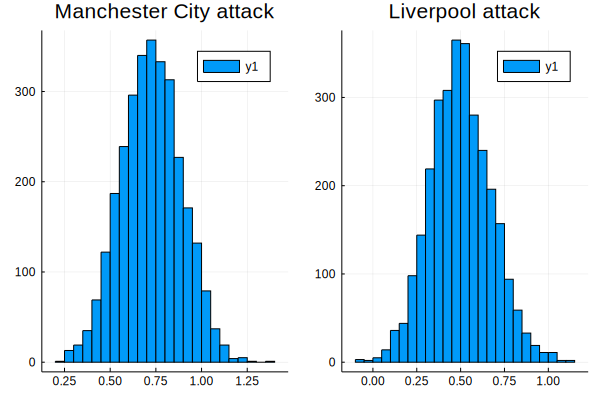

In [10]:
hh1 = histogram(mci_att_post, title="Manchester City attack")
hh2 = histogram(liv_att_post, title="Liverpool attack")
plot(hh1, hh2, layout=(1,2))

In [11]:
# This function simulates matches given the attach, defense and home parameters.
# The first pair of parameters alwas correspond to the home team.

function simulate_matches_(att₁, def₁, att₂, def₂, home, n_matches, home_team = 1)
    if home_team == 1
        logθ₁ = home + att₁ + def₂
        logθ₂ = att₂ + def₁

    elseif home_team == 2
        logθ₁ = att₁ + def₂
        logθ₂ = home + att₂ + def₁
    else
        return DomainError(home_team, "Invalid home_team value")
    end
    
    scores₁ = rand(LogPoisson(logθ₁), n_matches)
    scores₂ = rand(LogPoisson(logθ₂), n_matches)
    
    results = [(s₁, s₂) for (s₁, s₂) in zip(scores₁, scores₂)]
    
    return results
end

simulate_matches_ (generic function with 2 methods)

In [36]:
function simulate_matches(team1_att_post, team1_def_post, team2_att_post, team2_def_post, home_post, n_matches)
    
    team1_as_home_results = Tuple{Int64,Int64}[]
    team2_as_home_results = Tuple{Int64,Int64}[]
    
    for (t1_att, t1_def, t2_att, t2_def, home) in zip(team1_att_post, team1_def_post, 
                                                      team2_att_post, team2_def_post,
                                                      home_post)
        
        team1_as_home_results = vcat(team1_as_home_results, simulate_matches_(t1_att, t1_def,
                                                                              t2_att, t2_def, 
                                                                              home, n_matches, 1))
        
        team2_as_home_results = vcat(team2_as_home_results, simulate_matches_(t1_att, t1_def,
                                                                              t2_att, t2_def,
                                                                              home, n_matches, 2))
    end
    
    max_t1_as_home = maximum(map(x -> x[1], team1_as_home_results))
    max_t2_as_away = maximum(map(x -> x[2], team1_as_home_results))
    
    max_t1_as_away = maximum(map(x -> x[1], team2_as_home_results))
    max_t2_as_home = maximum(map(x -> x[2], team2_as_home_results))

    matrix_t1_as_home = zeros(Float64, (max_t1_as_home + 1, max_t2_as_away + 1))
    matrix_t2_as_home = zeros(Float64, (max_t1_as_away + 1, max_t2_as_home + 1))
    
    for match in team1_as_home_results
        matrix_t1_as_home[match[1] + 1, match[2] + 1] += 1
    end
    normalize!(matrix_t1_as_home, 1)
    
    for match in team2_as_home_results
        matrix_t2_as_home[match[1] + 1, match[2] + 1] += 1
    end
    normalize!(matrix_t2_as_home, 1)
    
    return matrix_t1_as_home, matrix_t2_as_home
end

simulate_matches (generic function with 1 method)

In [37]:
@time mci_as_home_simulations, liv_as_home_simulations = simulate_matches(mci_att_post, mci_def_post,
                                                                    liv_att_post, liv_def_post, post_home, 1000);

124.036462 seconds (18.53 M allocations: 134.808 GiB, 20.53% gc time)


In [38]:
function match_heatmaps(matrix_t1_as_home, matrix_t2_as_home,
                        team1_name="Team 1", team2_name="Team 2")    
    gr()   

    x_t1_home = string.(0:10)
    y_t1_home = string.(0:10)
    heat_t1_home = heatmap(x_t1_home,
                           y_t1_home,
                           matrix_t1_as_home[1:11, 1:11],
                           xlabel="$team2_name score", ylabel="$team1_name score",
                           title="$team1_name as home")
    
    x_t2_home = string.(0:10)
    y_t2_home = string.(0:10)
    heat_t2_home = heatmap(x_t2_home,
                           y_t2_home,
                           matrix_t2_as_home[1:11, 1:11],
                           xlabel="$team2_name score", ylabel="$team1_name score",
                           title="$team2_name as home")
    
    plot(heat_t1_home, heat_t2_home, layout=(1,2), size=(900, 300))
    current()   
end

match_heatmaps (generic function with 3 methods)

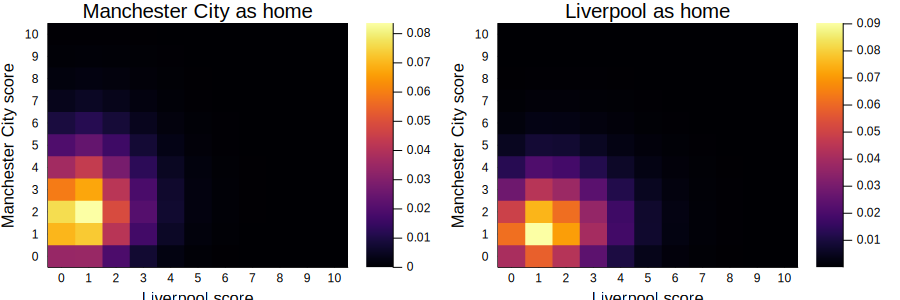

In [39]:
match_heatmaps(mci_as_home_simulations, liv_as_home_simulations, "Manchester City", "Liverpool")

In [40]:
function get_won_games(team1_as_home_results, team2_as_home_results)

    t1_as_home_total_matches = length(team1_as_home_results)
    t1_as_home_won = 0
    t2_as_away_won = 0
    t1_as_home_draw = 0
    
    for match in team1_as_home_results
        if match[1] > match[2]
            t1_as_home_won += 1
        elseif match[1] < match[2]
            t2_as_away_won += 1
        else
            t1_as_home_draw += 1
        end
    end
    
    t2_as_home_total_matches = length(team2_as_home_results)
    t1_as_away_won = 0
    t2_as_home_won = 0
    t2_as_home_draw = 0
    
    for match in team2_as_home_results
        if match[1] > match[2]
            t1_as_away_won += 1
        elseif match[1] < match[2]
            t2_as_home_won += 1
        else
            t2_as_home_draw += 1
        end
    end
    
    println("Team 1 won $(t1_as_home_won/t1_as_home_total_matches) times as home")
    println("Team 2 won $(t2_as_away_won/t1_as_home_total_matches) times as away")
    println("There were $(t1_as_home_draw/t1_as_home_total_matches) draws with Team 1 as home")
    println("")
    println("Team 1 won $(t1_as_away_won/t2_as_home_total_matches) times as away")
    println("Team 2 won $(t2_as_home_won/t2_as_home_total_matches) times as home")
    println("There were $(t2_as_home_draw/t2_as_home_total_matches) draws with Team 2 as home")
end

get_won_games (generic function with 1 method)

In [17]:
get_won_games(mci_as_home_simulations, liv_as_home_simulations)

LoadError: BoundsError

In [18]:
mci_as_home_simulations

19×13 Array{Float64,2}:
 0.157659     0.158705     0.0856172    …  3.08822e-7  0.0         0.0
 0.323471     0.339395     0.190867        4.32351e-6  9.26466e-7  0.0
 0.353916     0.385903     0.226323        7.10291e-6  2.16176e-6  0.0
 0.274593     0.312516     0.191151        8.02938e-6  2.7794e-6   3.08822e-7
 0.169829     0.201932     0.128799        7.41173e-6  1.85293e-6  0.0
 0.0898685    0.110695     0.0735185    …  7.72055e-6  9.26466e-7  9.26466e-7
 0.0417815    0.0539105    0.037336        4.63233e-6  6.17644e-7  3.08822e-7
 0.0176896    0.0238043    0.0172419       3.70587e-6  3.08822e-7  0.0
 0.00700254   0.00980943   0.00737128      9.26466e-7  6.17644e-7  0.0
 0.00262128   0.0037559    0.00301781      1.54411e-6  0.0         0.0
 0.000937275  0.00143139   0.00115561   …  6.17644e-7  0.0         0.0
 0.000308205  0.000484851  0.000417219     0.0         0.0         0.0
 0.000100367  0.00017047   0.000148852     0.0         0.0         0.0
 3.86028e-5   6.29997e-5   5.404

### Results of the Champion's league
###### Manchester City vs. Liverpool
* 0 - 3
* 1 - 2

So we are going to search for the value (0+1, 3+1) in the first matrix and (1+1, 2+1) in the second matrix

In [45]:
get_score_probability(score1::Int64, score2::Int64, simulation) = simulation[score1+1, score2+1]

get_score_probability (generic function with 1 method)

In [47]:
get_score_probability(2, 1, mci_as_home_simulations)

0.08361933333333334

In [43]:
function win_and_lose_probability(simulation)
    
    team1_winning_prob = 0
    team2_winning_prob = 0
    draw_prob = 0
    
    for i in 1:size(simulation, 1)
        for j in 1:size(simulation, 2)
            if i > j
                team1_winning_prob += simulation[i,j]
            elseif i < j
                team2_winning_prob += simulation[i,j]
            else
                draw_prob += simulation[i,j]
            end
        end
    end
    
    println("Team 1 has $team1_winning_prob probability of winning")
    println("Team 2 has $team2_winning_prob probability of winning")
    println("The probability of a draw is $draw_prob")
    
    return team1_winning_prob, team2_winning_prob, draw_prob
end

win_and_lose_probability (generic function with 1 method)

In [44]:
win_and_lose_probability(mci_as_home_simulations)

Team 1 has 0.6496860000000004 probability of winning
Team 2 has 0.17024066666666662 probability of winning
The probability of a draw is 0.1800733333333333


(0.6496860000000004, 0.17024066666666662, 0.1800733333333333)